In [1]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image
import torch
import os
import torch.nn as nn
import math
from ocr_label_converter import OCRLabelConverter

In [2]:
alphabet = """Only thewigsofrcvdampbkuq.$A-210xT5'MDL,RYHJ"ISPWENj&BC93VGFKz();#:!7U64Q8?+*ZX/%"""
converter = OCRLabelConverter(alphabet)
len(alphabet)

81

In [28]:
import torch

class SynthCollator(object):
    def __init__(self, alphabet=alphabet):
        self.converter = OCRLabelConverter(alphabet)

    def __call__(self, batch):
        # Extract indexes and labels
        indexes = [item['idx'] for item in batch]
        labels = [item['label'] for item in batch]
        
        # Encode labels
        encoded_labels, label_lengths = self.converter.encode(labels)
        
        # Stack images into a tensor
        images = torch.stack([item['img'].detach().clone().float() for item in batch])
        
        # Create the output dictionary
        item = {
            'img': images,  # (batch_size, C, H, W)
            'idx': indexes,  # List of indices
            'label': encoded_labels,  # Tensor of encoded labels
            'label_lengths': label_lengths.detach().clone()  # Tensor of label lengths
        }
        return item

In [51]:
#custom 
class Ocr_Dataset(Dataset):
    def __init__(self,dir ,collate_fn = None):
        self.dir = dir
        self.imgpath = os.listdir(dir)
        f = lambda x: os.path.join(self.dir, x)
        self.images_path = list(map(f,self.imgpath))
        transform_list =  [ transforms.Resize((32,90)),
                            transforms.RandomRotation(15), 
                            transforms.Grayscale(1),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5,), (0.5,)) 
                            ]
        self.transform = transforms.Compose(transform_list)

        
        self.collate_fn = collate_fn
    
    def __len__(self):
        return len(self.imgpath)
    
    def __getitem__(self, index):
        image_path = self.images_path[index]
        
        image_name = os.path.basename(image_path)
        img = Image.open(image_path)
        if self.transform is not None:
            img = self.transform(img)
            
        item = {'img':img,'idx':index}
        item["label"] = image_name.split("_")[0]
    

        return item
            
            
        

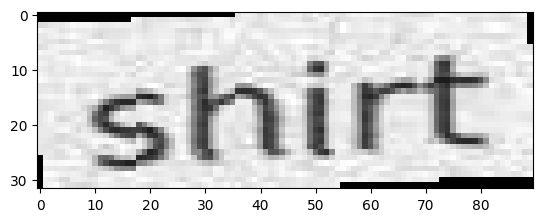

In [174]:
dir = "/home/saurav/Desktop/get_the_text/data/Train"
valid_dir = "/home/saurav/Desktop/get_the_text/data/Test"

import matplotlib.pyplot as plt
import numpy as np
dataset = Ocr_Dataset(dir)
valid_ocr = Ocr_Dataset(valid_dir)
len(dataset)

img = np.asarray(valid_ocr[1]['img'])  
img = np.squeeze(img)
plt.imshow(img,cmap='gray')


In [125]:
import torch
import torch.nn as nn

class BidirectionalLSTM(nn.Module):
    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()
        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)

    def forward(self, input):
        self.rnn.flatten_parameters()
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)
        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)
        return output

class CRNN(nn.Module):
    def __init__(self, leakyRelu=False, alphabet=None):
        super(CRNN, self).__init__()

        # Kernel sizes, padding, strides, and number of filters
        ks = [3, 3, 3, 3]  # Reduced layers
        ps = [1, 1, 1, 1]  # Padding to maintain size where needed
        ss = [1, 1, 1, 1]  # Strides
        nm = [64, 128, 256, 512]  # Number of filters

        self.cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = 1 if i == 0 else nm[i - 1]
            nOut = nm[i]
            self.cnn.add_module(f'conv{i}', nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                self.cnn.add_module(f'batchnorm{i}', nn.BatchNorm2d(nOut))
            if leakyRelu:
                self.cnn.add_module(f'relu{i}', nn.LeakyReLU(0.2, inplace=True))
            else:
                self.cnn.add_module(f'relu{i}', nn.ReLU(True))

        # Build CNN
        convRelu(0)  # Input: [batch, 1, 32, 90] -> [batch, 64, 32, 90]
        self.cnn.add_module('pooling0', nn.MaxPool2d((2, 2), stride=(2, 2)))  # [batch, 64, 16, 45]
        convRelu(1)  # [batch, 128, 16, 45]
        self.cnn.add_module('pooling1', nn.MaxPool2d((2, 2), stride=(2, 1)))  # [batch, 128, 8, 45]
        convRelu(2, True)  # [batch, 256, 8, 45]
        self.cnn.add_module('pooling2', nn.MaxPool2d((2, 2), stride=(2, 1)))  # [batch, 256, 4, 45]
        convRelu(3, True)  # [batch, 512, 4, 45]
        self.cnn.add_module('pooling3', nn.MaxPool2d((4, 1), stride=(4, 1)))  # [batch, 512, 1, 45]
        self.cnn.add_module('conv_final', nn.Conv2d(512, 512, (1, 5), stride=(1, 1), padding=(0, 2)))  # [batch, 512, 1, 81]

        # RNN
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, 256, 256),  # Input size: 512 (channels)
            BidirectionalLSTM(256, 256, 81)  # Output size: 81 (alphabet size)
        )

        # RNN
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, 256, 256),  # Input size: 512 (channels)
            BidirectionalLSTM(256, 256, 81)  # Output size: 81 (alphabet size)
        )

    def forward(self, input):
        # Input shape: [batch, channels, height, width] = [32, 1, 240, 320]
        conv = self.cnn(input)  # Output: [32, 512, 1, 81]
        b, c, h, w = conv.size()
        assert h == 1, f"Height must be 1, got {h}"
        conv = conv.squeeze(2)  # [32, 512, 81]
        conv = conv.permute(2, 0, 1)  # [81, 32, 512] (T, batch, input_size)

        # RNN
        output = self.rnn(conv)
        output = output.transpose(1,0)  
        return output

In [85]:
class CustomCTCLoss(torch.nn.Module):
    # T x B x H => Softmax on dimension 2
    def __init__(self, dim=2):
        super().__init__()
        self.dim = dim
        self.ctc_loss = torch.nn.CTCLoss(reduction='mean', zero_infinity=True)

    def forward(self, logits, labels,
            prediction_sizes, target_sizes):
        EPS = 1e-7
        loss = self.ctc_loss(logits, labels, prediction_sizes, target_sizes)
        loss = self.sanitize(loss)
        return self.debug(loss, logits, labels, prediction_sizes, target_sizes)
    
    def sanitize(self, loss):
        EPS = 1e-7
        if abs(loss.item() - float('inf')) < EPS:
            return torch.zeros_like(loss)
        if math.isnan(loss.item()):
            return torch.zeros_like(loss)
        return loss

    def debug(self, loss, logits, labels,
            prediction_sizes, target_sizes):
        if math.isnan(loss.item()):
            print("Loss:", loss)
            print("logits:", logits)
            print("labels:", labels)
            print("prediction_sizes:", prediction_sizes)
            print("target_sizes:", target_sizes)
            raise Exception("NaN loss obtained. But why?")
        return loss

In [86]:
def loss_func(logits,target,pred_size,target_size):
    return CustomCTCLoss(logits,target,pred_size,target_size)
converter = OCRLabelConverter(alphabet)
 

In [175]:
train_dataloader = DataLoader(
    dataset=dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=SynthCollator()

 
)
valid_dataloader = DataLoader(
    dataset=valid_ocr,
    collate_fn=SynthCollator(),
    shuffle=True,
    batch_size=32
)

for batch in train_dataloader:
    images = batch['img']  # (batch_size, 1, H, max_width)
    labels = batch['label']  # Encoded labels tensor
    label_lengths = batch['label_lengths']  # Tensor of label lengths
    print(f"Batch images shape: {images.shape}")
    print(f"Encoded labels shape: {labels.shape}")
    print(f"Label lengths: {label_lengths}")
    
    break
len(train_dataloader)

Batch images shape: torch.Size([32, 1, 32, 90])
Encoded labels shape: torch.Size([241])
Label lengths: tensor([ 4,  8, 11,  7,  9,  8,  7, 11,  9,  6, 14,  5,  7,  7,  4,  7,  7, 10,
         7,  9, 10,  5,  5,  6,  7,  5,  7, 10,  5, 10,  6,  8],
       dtype=torch.int32)


934

In [89]:
import torch
import torch.nn as nn

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model = CRNN().to(device)
model.train()

# Loss and optimizer
criterion = CustomCTCLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
batch_size = 32

for epoch in range(num_epochs):
    total_train_loss = 0
    total_valid_loss = 0

    # Training phase
    model.train()
    for batch in train_dataloader:
        # Get the batch data
        images = batch['img'].to(device)  # (actual_batch_size, 1, H, max_width)
        labels = batch['label'].to(device)  # Encoded labels
        label_lengths = batch['label_lengths'].to(device)  # (actual_batch_size,)
        
        # Get the actual batch size from the batch
        actual_batch_size = images.shape[0]
        
        # Forward pass
        optimizer.zero_grad()
        logits = model(images)  # [T, batch, num_classes], e.g., [81, actual_batch_size, 81]
        
        # Prepare for CTC loss
        logits = logits.transpose(0, 1)  # [batch, T, num_classes]
        log_probs = logits.log_softmax(2)  # [batch, T, num_classes]
        
        T, _, _ = log_probs.shape
        prediction_sizes = torch.full((actual_batch_size,), T, dtype=torch.long).to(device)
        
        if (prediction_sizes > T).any():
            raise ValueError(f"prediction_sizes contains values greater than T={T}: {prediction_sizes}")
        
        # Compute loss
        loss = criterion(log_probs, labels, prediction_sizes, label_lengths)
    
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()

           
    total_train_loss = total_train_loss/len(train_dataloader)
            # Print training and validation results
    print(f"Epoch [{epoch}/{num_epochs}], "
                f"Train Loss: {total_train_loss:.4f},")

Epoch [0/10], Train Loss: 3.4526,
Epoch [1/10], Train Loss: 0.9227,
Epoch [2/10], Train Loss: 0.1079,
Epoch [3/10], Train Loss: 0.0569,
Epoch [4/10], Train Loss: 0.0513,
Epoch [5/10], Train Loss: 0.0512,
Epoch [6/10], Train Loss: 0.0325,
Epoch [7/10], Train Loss: 0.0306,
Epoch [8/10], Train Loss: 0.0274,
Epoch [9/10], Train Loss: 0.0349,


In [94]:
torch.save(model, "ocr_model_final.pth")


In [97]:

test_model_ = torch.load("ocr_model_final.pth",weights_only = False)

test_model_.eval()

CRNN(
  (cnn): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ReLU(inplace=True)
    (pooling0): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace=True)
    (pooling1): MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (pooling2): MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (pooling3): MaxPool2

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def get_accuracy():

    model = test_model_
    model.eval()
    converter = OCRLabelConverter(alphabet)

    labels, predictions, images = [], [], []
    with torch.no_grad():
        for iteration, batch in enumerate(valid_dataloader):
            input_, targets = batch['img'].to(device), batch['label']
            print(input_.shape)
            images.extend(input_.squeeze().detach())
            labels.extend(targets)
            targets = batch['label']
            logits = model(input_).transpose(1, 0)
            logits = torch.nn.functional.log_softmax(logits, 2)
            logits = logits.contiguous().cpu()
            T, B, H = logits.size()
            pred_sizes = torch.LongTensor([T for i in range(B)])
            probs, pos = logits.max(2)
            pos = pos.transpose(1, 0).contiguous().view(-1)
            sim_preds = converter.decode(pos.data, pred_sizes.data, raw=False)
            predictions.extend(sim_preds)
            
#make_grid(images[:10], nrow=2)
    fig=plt.figure(figsize=(8, 8))
    columns = 4
    rows = 5
    pairs = list(zip(images, predictions))
    indices = np.random.permutation(len(pairs))
    for i in range(1, columns*rows +1):
        img = images[indices[i]]
        img = np.array(img * 255.0, dtype=np.uint8)
        fig.add_subplot(rows, columns, i)
        plt.title(predictions[indices[i]])
        plt.axis('off')
        plt.imshow(img)
    plt.show()

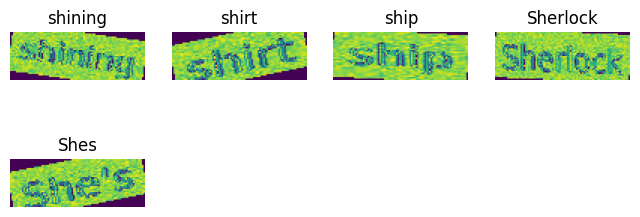

In [182]:
try:
    get_accuracy()
except:
    pass
